In [1]:
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import warnings

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.5f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

# Data

## Read

In [2]:
# Read in the crime data for Florida for 2016, listed by city
florida_crime = pd.read_excel('./florida_2017.xls')
florida_crime.columns = ['city', 'population', 'violent_crime', 'murder', 'rape', 'robbery',
       'assault', 'property_crime', 'burglary', 'larceny_theft',
       'motor_vehicle_theft', 'arson']
florida_crime.set_index('city', inplace=True)

crime_cols = ['violent_crime', 'murder', 'rape', 'robbery', 
              'assault', 'property_crime', 'burglary', 'larceny_theft', 
              'motor_vehicle_theft', 'arson']

## Inspect

In [3]:
florida_crime.describe()

,population,violent_crime,murder,rape,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson
count,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000
mean,35417.45423,170.28521,2.17254,14.31338,44.07394,109.72535,1129.05986,171.60563,863.82042,93.63380,2.83803
std,74789.22599,467.35710,8.16537,40.50150,125.33079,300.15150,2725.22239,441.63691,2041.26924,254.30202,8.62213
min,92.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,4264.75000,9.00000,0.00000,0.00000,1.00000,5.75000,92.00000,16.00000,66.25000,5.00000,0.00000
50%,12871.50000,40.00000,0.00000,4.00000,7.00000,26.00000,348.50000,60.00000,266.00000,18.00000,0.00000
75%,38706.50000,137.50000,1.00000,12.00000,29.25000,90.50000,1085.00000,162.00000,846.00000,76.00000,2.00000
max,894638.00000,5648.00000,109.00000,538.00000,1376.00000,3625.00000,31551.00000,5646.00000,22980.00000,2925.00000,96.00000


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Log of Population')

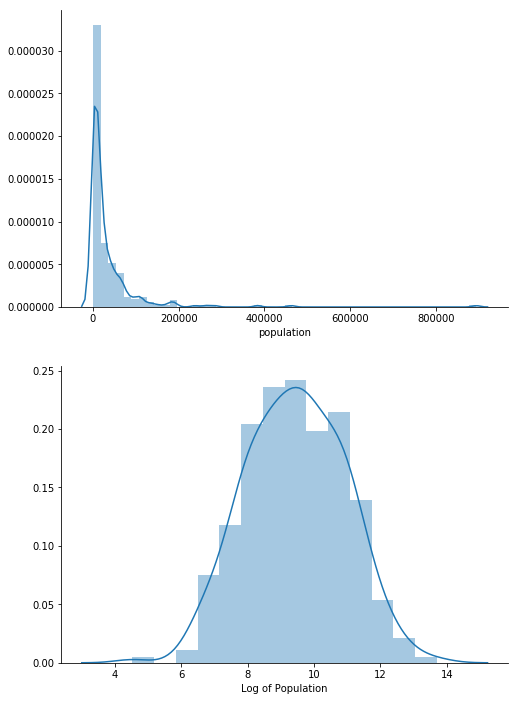

In [4]:
fig = plt.figure(figsize=(8,12))
ax1, ax2 = fig.subplots(2,1)
sns.distplot(florida_crime["population"], ax=ax1)
sns.despine(ax=ax1)
sns.distplot(np.log(florida_crime["population"]), ax=ax2)
sns.despine(ax=ax2)
ax2.set_xlabel("Log of Population")

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


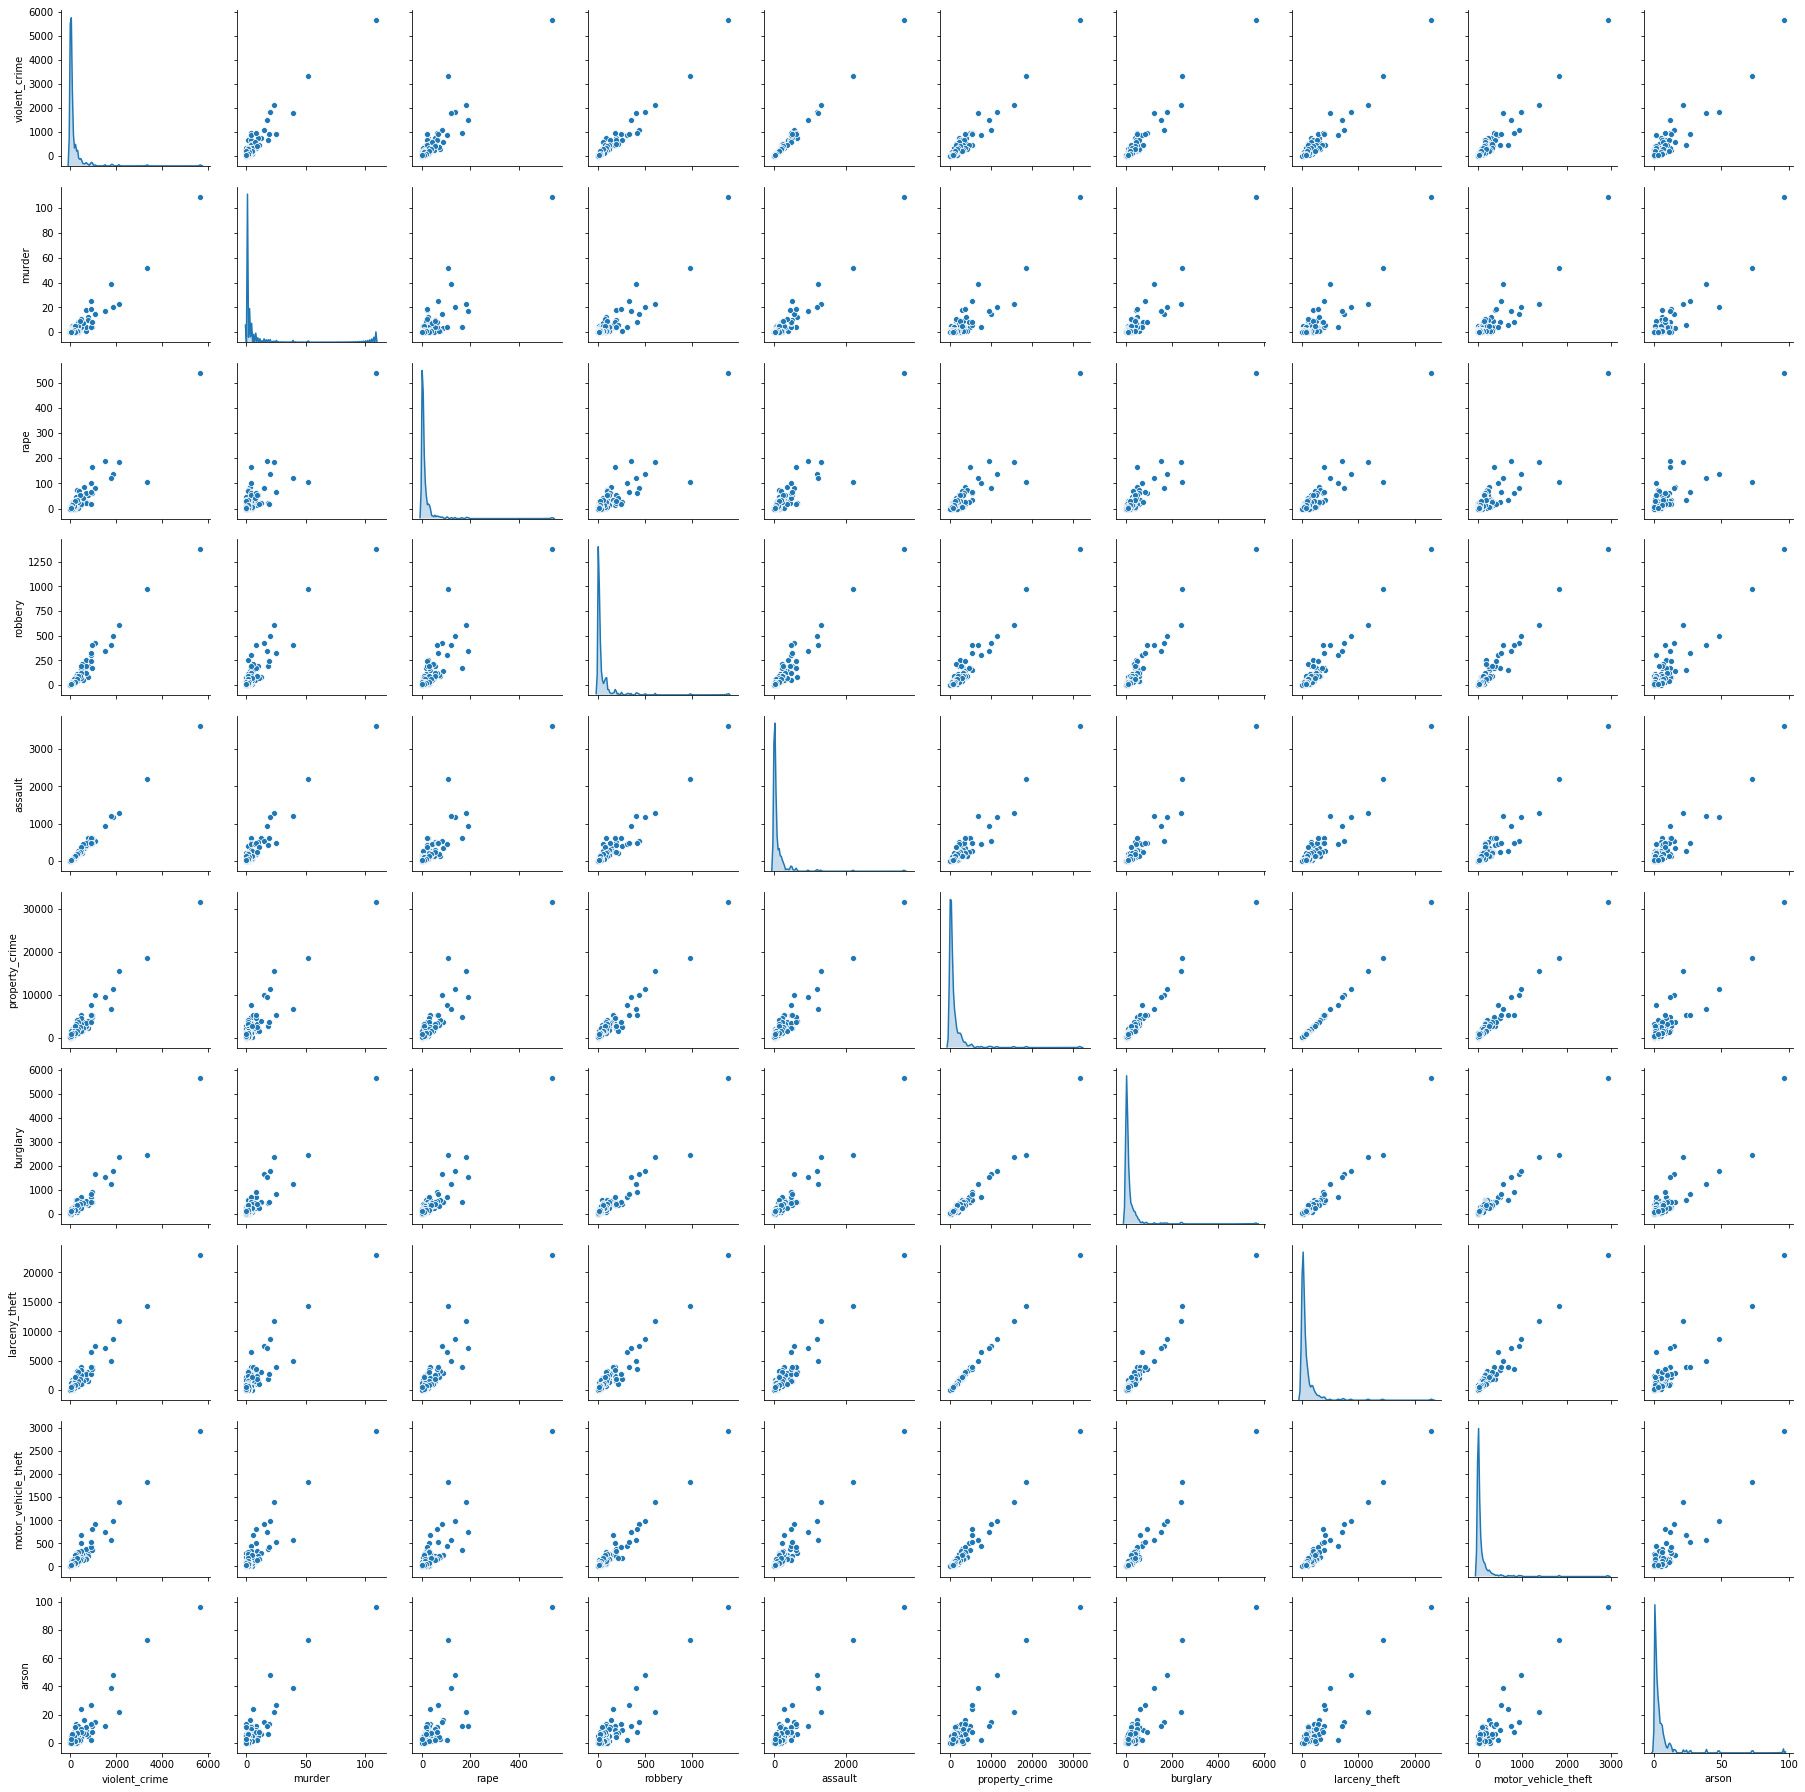

In [6]:
g = sns.pairplot(florida_crime, vars=crime_cols, diag_kind="kde")

So all crime metrics exhibit left skewness (my suspicion is population is quite correlated with each of these stats, and that is also quite left skewed however log transforming the population variable significantly reduces this skewness so lets log transform all of these as well.

## Clean

The only cleaning we are going to do here is to replace -inf values (in the crime_log cols) with a large negative number (in this case -100).

## Transform

In [3]:
florida_crime["population_log"] = np.log(florida_crime["population"])

# the one issue with this is dealing with rows where there is zero crime, log(0) = -inf
# so replace this -inf value with a large negative number?
for crime in crime_cols:
    florida_crime[crime + "_log"] = np.log(florida_crime[crime])
    florida_crime[crime + "_log"].replace(-math.inf, np.nan, inplace = True)
    
## Population
threshold_low = florida_crime["population_log"].quantile(0.1)
threshold_medium = florida_crime["population_log"].quantile(0.9)

florida_crime["population_low"] = florida_crime["population_log"].between(0,threshold_low)
florida_crime["population_medium"] = florida_crime["population_log"].between(threshold_low, threshold_medium)
florida_crime["population_high"] = florida_crime["population_log"] >= threshold_medium

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [5]:
# create a new column for population_group
florida_crime["population_group"] = np.nan

low = florida_crime.query("population_low == 1")
medium = florida_crime.query("population_medium == 1")
high = florida_crime.query("population_high == 1")

florida_crime.loc[medium.index, "population_group"] = 2
florida_crime.loc[high.index, "population_group"] = 3
florida_crime.loc[low.index, "population_group"] = 1

# 2. Indicator Variables

## Crimes
florida_crime["has_violent_crime"] = np.where(florida_crime["violent_crime"] > 0, 1, 0)
florida_crime["has_murder"] = np.where(florida_crime["murder"] > 0, 1, 0)
florida_crime["has_rape"] = np.where(florida_crime["rape"] > 0, 1, 0)
florida_crime["has_robbery"] = np.where(florida_crime["robbery"] > 0, 1, 0)
florida_crime["has_assault"] = np.where(florida_crime["assault"] > 0, 1, 0)
florida_crime["has_property_crime"] = np.where(florida_crime["property_crime"] > 0, 1, 0)
florida_crime["has_bulglary"] = np.where(florida_crime["burglary"] > 0, 1, 0)
florida_crime["has_larceny_theft"] = np.where(florida_crime["larceny_theft"] > 0, 1, 0)
florida_crime["has_motor_vehicle_theft"] = np.where(florida_crime["motor_vehicle_theft"] > 0, 1, 0)
florida_crime["has_arson"] = np.where(florida_crime["arson"] > 0, 1, 0)

florida_crime.groupby("population_group").mean()

,population,violent_crime,murder,rape,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,...,has_violent_crime,has_murder,has_rape,has_robbery,has_assault,has_property_crime,has_bulglary,has_larceny_theft,has_motor_vehicle_theft,has_arson
population_group,,,,,,,,,,,,,,,,,,,,,
1.00000,1131.65517,4.34483,0.06897,0.24138,0.51724,3.51724,38.86207,7.17241,28.20690,3.48276,...,0.68966,0.03448,0.17241,0.27586,0.58621,0.96552,0.82759,0.93103,0.55172,0.06897
2.00000,20451.58407,89.83186,1.02212,7.31858,21.33628,60.15487,604.69912,94.31858,465.81858,44.56195,...,0.97788,0.41150,0.78319,0.86726,0.95575,1.00000,1.00000,1.00000,0.96460,0.49115
3.00000,186333.82759,963.20690,13.24138,82.89655,264.82759,602.24138,6305.65517,938.34483,4801.10345,566.20690,...,1.00000,0.93103,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.96552


There are drastic differences in crime rates among cities with low populations versus medium and high populations. This implies using a separate model for low populations. The average population for the low group is 1132, 20,452 for the medium group and 186,334 for the high group. 

When comparing medium to high population cities, the murder rate is more than double in high population cities, saw almost twice as many arson cases and more than a 20% increase in rapes. Hopefully our model picks up on this fact.

The value that we wish to predict are property crimes, and in medium size cities the average was 604.7 and 6305.6 for high population cities: about a tenfold increase (for a little over a 9 fold increase in population).

In [6]:
crime_log_cols = [crime + "_log" for crime in crime_cols]
florida_crime[crime_log_cols].corr()

,violent_crime_log,murder_log,rape_log,robbery_log,assault_log,property_crime_log,burglary_log,larceny_theft_log,motor_vehicle_theft_log,arson_log
violent_crime_log,1.00000,0.70855,0.86299,0.93968,0.99104,0.91779,0.91528,0.90717,0.89197,0.71680
murder_log,0.70855,1.00000,0.61962,0.71479,0.72557,0.66266,0.68983,0.64082,0.69778,0.68365
rape_log,0.86299,0.61962,1.00000,0.81427,0.83118,0.83915,0.82816,0.83381,0.79955,0.64707
robbery_log,0.93968,0.71479,0.81427,1.00000,0.90473,0.91708,0.90447,0.90260,0.90114,0.67596
assault_log,0.99104,0.72557,0.83118,0.90473,1.00000,0.89474,0.90129,0.88323,0.86648,0.71625
property_crime_log,0.91779,0.66266,0.83915,0.91708,0.89474,1.00000,0.95814,0.99591,0.93512,0.67918
burglary_log,0.91528,0.68983,0.82816,0.90447,0.90129,0.95814,1.00000,0.93363,0.88226,0.66653
larceny_theft_log,0.90717,0.64082,0.83381,0.90260,0.88323,0.99591,0.93363,1.00000,0.92896,0.67221
motor_vehicle_theft_log,0.89197,0.69778,0.79955,0.90114,0.86648,0.93512,0.88226,0.92896,1.00000,0.66215
arson_log,0.71680,0.68365,0.64707,0.67596,0.71625,0.67918,0.66653,0.67221,0.66215,1.00000


For linear regression to be applied to a data set successfully, the input features must have little collinearity, therefore any variables that have a correlation greater than 0.5 we will transform these into components via PCA. As can be seen above, all of these features are weak-to-strongly correlated with each other (the lowest correlation is 61.l9%).

### PCA

In [7]:
from sklearn.decomposition import PCA

def get_components(data, cols_to_combine):
    # dont really want to drop all NaN values so just replace with -23
    # play around with this parameter and see what/if any effect(s) it has on performance
    x = data[crime_log_cols].replace(np.nan, -23).values  
    pca = PCA(n_components=len(cols_to_combine))
    pca.fit(x)
    components = pca.transform(x)
    components = pd.DataFrame(components)
    components.columns = ["PC" + str(i+1) for i in range(0, len(cols_to_combine))]
    components.index = data.index
    return pca, components

# let;s just PCA all crimes
pca, crime_components = get_components(florida_crime, crime_log_cols)
print("Variance explained by each component")
print(pca.explained_variance_ / pca.explained_variance_.sum())
crime_components.corr()
var_explained = (pca.explained_variance_ / pca.explained_variance_.sum())
print("Variance Explained by first n components\n")
print("----------------------")
for i in range(1,11):
    print("{}: {}".format(i, var_explained[:i].sum()))

Variance explained by each component
[0.5671198  0.14221916 0.09724448 0.07571058 0.05290467 0.03302928
 0.01730964 0.00902353 0.00448462 0.00095423]
Variance Explained by first n components

----------------------
1: 0.5671197998541629
2: 0.7093389590078033
3: 0.8065834388388
4: 0.8822940215282429
5: 0.9351986887644655
6: 0.968227965543886
7: 0.985537610482898
8: 0.9945611409109608
9: 0.9990457658929849
10: 0.9999999999999999


In [8]:
# Now attach the population_log and outcome (property_crime) variables to our PCA matrix
crime_components = crime_components.join(florida_crime["property_crime"])
crime_components = crime_components.join(florida_crime["population_log"])

# remember we are not building a model to work on low population cities, so discard these rows for now
crime_components = crime_components.query("population_log > {}".format(threshold_low))

# attach our population_medium and population_high variables
crime_components = crime_components.join(florida_crime["population_low"])
crime_components = crime_components.join(florida_crime["population_medium"])
crime_components = crime_components.join(florida_crime["population_high"])

# attach indicator variables
crime_components = crime_components.join(florida_crime["has_arson"])
crime_components = crime_components.join(florida_crime["has_assault"])
crime_components = crime_components.join(florida_crime["has_bulglary"])
crime_components = crime_components.join(florida_crime["has_larceny_theft"])
crime_components = crime_components.join(florida_crime["has_motor_vehicle_theft"])
crime_components = crime_components.join(florida_crime["has_rape"])
crime_components = crime_components.join(florida_crime["has_robbery"])
crime_components = crime_components.join(florida_crime["has_violent_crime"])
crime_components = crime_components.join(florida_crime["has_murder"])
crime_components = crime_components.join(florida_crime["murder"])
crime_components = crime_components.join(florida_crime["motor_vehicle_theft"])

In [9]:
crime_components.corr()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,has_assault,has_bulglary,has_larceny_theft,has_motor_vehicle_theft,has_rape,has_robbery,has_violent_crime,has_murder,murder,motor_vehicle_theft_log
PC1,1.00000,-0.24521,0.11124,-0.13593,-0.03309,-0.16446,-0.26961,0.06372,-0.10865,-0.06374,...,-0.42832,nan,nan,-0.41339,-0.69770,-0.61324,-0.39049,-0.69976,-0.33607,-0.78696
PC2,-0.24521,1.00000,0.08349,-0.13432,-0.05704,-0.08263,-0.14542,0.12444,-0.13454,0.04445,...,-0.23733,nan,nan,-0.27701,-0.20546,-0.32299,-0.26981,0.75442,0.21446,0.29292
PC3,0.11124,0.08349,1.00000,0.05462,0.06074,0.03210,0.06154,-0.06050,0.07071,-0.04718,...,0.08096,nan,nan,0.06763,0.02794,-0.03460,0.13304,0.36502,0.03688,-0.12619
PC4,-0.13593,-0.13432,0.05462,1.00000,-0.15389,-0.07797,0.06514,0.00118,-0.19374,0.13317,...,-0.24184,nan,nan,-0.19012,0.72499,-0.08320,-0.22400,0.00484,-0.02489,0.08204
PC5,-0.03309,-0.05704,0.06074,-0.15389,1.00000,0.22251,0.17765,0.07304,-0.13636,0.17791,...,-0.47127,nan,nan,-0.02627,-0.13739,0.60981,-0.26658,0.04495,0.00388,0.06069
PC6,-0.16446,-0.08263,0.03210,-0.07797,0.22251,1.00000,-0.42095,-0.18695,-0.17779,0.34552,...,0.30970,nan,nan,-0.45001,0.07763,0.43867,0.30927,0.08023,-0.02916,0.13864
PC7,-0.26961,-0.14542,0.06154,0.06514,0.17765,-0.42095,1.00000,0.07640,-0.16413,-0.74394,...,0.07137,nan,nan,0.78190,0.31541,0.36220,0.13544,0.12575,-0.13281,-0.38913
PC8,0.06372,0.12444,-0.06050,0.00118,0.07304,-0.18695,0.07640,1.00000,0.36735,-0.26813,...,-0.42498,nan,nan,0.04031,-0.10030,-0.11257,0.30931,0.00866,0.01102,-0.11698
PC9,-0.10865,-0.13454,0.07071,-0.19374,-0.13636,-0.17779,-0.16413,0.36735,1.00000,-0.04880,...,0.15106,nan,nan,0.23021,-0.00263,0.02178,0.44447,-0.00343,0.20615,0.39609
PC10,-0.06374,0.04445,-0.04718,0.13317,0.17791,0.34552,-0.74394,-0.26813,-0.04880,1.00000,...,-0.13095,nan,nan,-0.54464,0.03055,0.05139,-0.29016,0.02504,0.27162,0.61980


This correlation matrix looks much better! We still see some collinearity, particularly in the first component and the seventh, so we will eliminate these. 

## Split

Here we split the 2017 Florida crime data into a train and test set (70/30).

In [23]:
# Do a 70/30 split
# If we do not set the random seed, we will get different samples every time,
# thus different models
train = crime_components.sample(frac=0.7, random_state=41)
test_cities = list(set(crime_components.index).difference(set(train.index)))
test = crime_components.loc[test_cities,:]
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (178, 27)
Test shape: (77, 27)


### Inspect Sets
We want to look for any abnormalities in the distribution of any predictor.

In [ ]:
g = sns.pairplot(train, diag_kind="kde")

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning

As suspected we really should only keep the first 3 principal components, but looking at the distributions components 9 and 10 should also be included. We will verify this in the next section.

# Model

## Build

In [24]:
import statsmodels.formula.api as smf
formula1 = "property_crime ~ population_log + population_low + population_high + murder + motor_vehicle_theft"
# Fit the model to our data using the formula.
lm1 = smf.ols(formula=formula1, data=crime_components).fit()
print("Model Parameters\n===========================================")
print(lm1.params)
print("p-values\n===========================================")
print(lm1.pvalues)
print("\n\nR-Squared: {}".format(lm1.rsquared))

Model Parameters
Intercept                 -938.69776
population_low[T.True]      -0.00000
population_high[T.True]    262.96502
population_log             116.93650
murder                      25.09741
motor_vehicle_theft          9.27853
dtype: float64
p-values
Intercept                 0.00153
population_low[T.True]    0.00018
population_high[T.True]   0.04651
population_log            0.00021
murder                    0.00428
motor_vehicle_theft       0.00000
dtype: float64


R-Squared: 0.9747798150428904


## Evaluate

In [25]:
print("Average property crime: {}".format(train["property_crime"].mean()))
print("Average error made by model: {}".format(lm1.resid.mean()))
print("Average error standard deviation: {}".format(lm1.resid.std()))

Average property crime: 1314.6516853932585
Average error made by model: -3.798477872110465e-13
Average error standard deviation: 452.626442877965


Now let us see how this model performs on the test set.

In [26]:
pred = pd.DataFrame(lm1.predict(test), columns=["predicted"])
pred = pred.join(test["property_crime"])

pred["residual"] = pred["property_crime"] - pred["predicted"]
pred.head()

,predicted,property_crime,residual
city,,,
Vero Beach,386.05080,490,103.94920
Homestead,2050.61398,2482,431.38602
Tampa,7067.71925,6702,-365.71925
Longwood,472.60073,427,-45.60073
Safety Harbor,490.20309,249,-241.20309


In [27]:
print("Average property crime: {}".format(test["property_crime"].mean()))
print("Average error made by model: {}".format(pred["residual"].mean()))
print("Average error standard deviation: {}".format(pred["residual"].std()))

Average property crime: 1110.6233766233765
Average error made by model: 6.502814421122933
Average error standard deviation: 414.70655799869786


## Revise

I actually iteratively went through this process, but did not write down the formula used at each step.

# Conclusions

We ended up not even using any of the principal components, however log-transforming the population variable was critical, as was specifying what population group the data belongs to and including the murder and motor vehicle theft counts; these features were very different among the 2 groups. After refining our model, we get an R^2 value of 0.974 with the model under-predicting property crimes in the train set, but over-predicting the property crimes in the test set. The standard deviation of the residuals decreased by 8 to 9 percent when predicting on the test set versus the train set. 